<a href="https://colab.research.google.com/github/Vaidehi-9/ECON3916-33674-Statistical-Machine-Learning/blob/main/Lab_4/%5BClass_4_%7C_Lab%5D_Descriptive_Statistics_%E2%80%94_Robustness_in_a_Skewed_World.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64


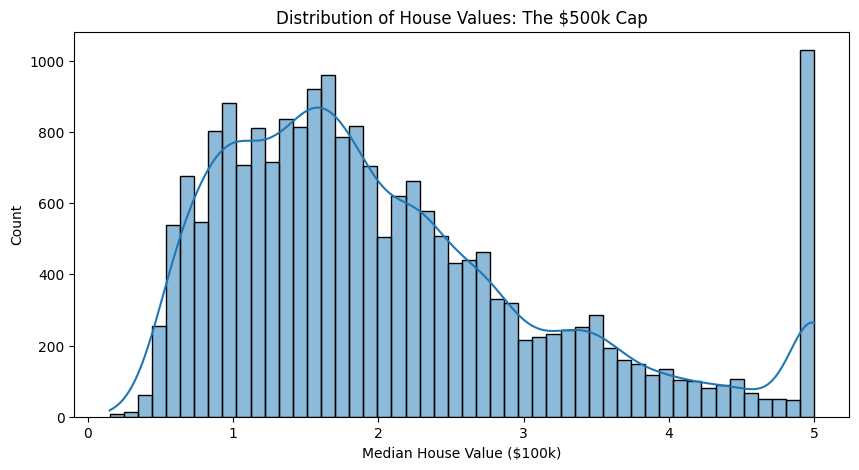

In [19]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. Ingest Data
data = fetch_california_housing(as_frame=True)
df = data.frame
df.describe()
# 2. Inspect the "Ceiling Effect"
print(df['MedHouseVal'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['MedHouseVal'], bins=50, kde=True)
plt.title("Distribution of House Values: The $500k Cap")
plt.xlabel("Median House Value ($100k)")
plt.show()


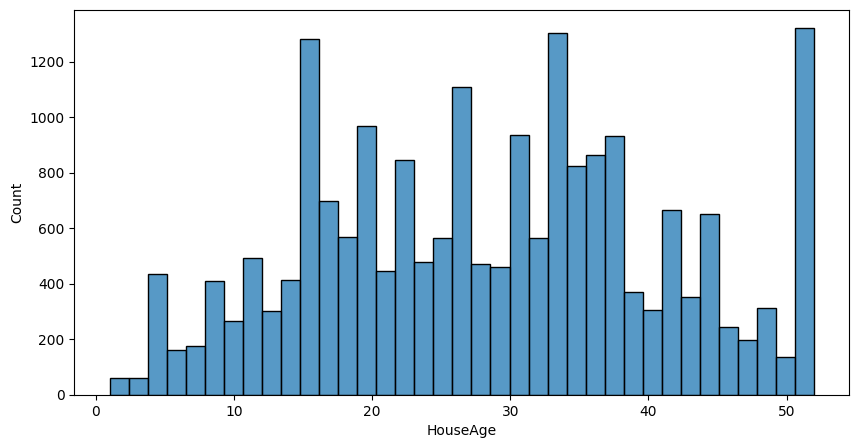

In [20]:

plt.figure(figsize=(10, 5))
sns.histplot(df['HouseAge'])
plt.show()


In [21]:
def flag_outliers_iqr(df, column):
    # Calculate Quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the "Tukey Fence"
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return Boolean Mask
    return (df[column] < lower_bound) | (df[column] > upper_bound)

# Apply to Median Income
df['outlier_iqr'] = flag_outliers_iqr(df, 'MedInc')

print(f"Manual Outliers Detected: {df['outlier_iqr'].sum()}")
print("These are primarily the 'Wealthy' districts.")

Manual Outliers Detected: 681
These are primarily the 'Wealthy' districts.


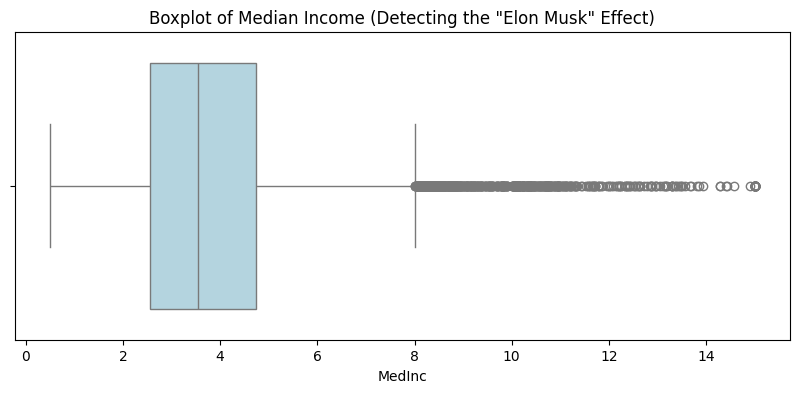

In [22]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['MedInc'], color='lightblue')
plt.title('Boxplot of Median Income (Detecting the "Elon Musk" Effect)')
plt.show()

In [23]:
# Initialize the model
# contamination=0.05: We estimate ~5% of the data is anomalous
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Features to analyze (Income, House Age, Average Rooms)
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']


# Fit and Predict (-1 = Outlier, 1 = Normal)
preds = iso_forest.fit_predict(df[features])

# Map to boolean (True if outlier)
df['outlier_iso'] = preds == -1

print(f"Algorithmic Outliers Detected: {df['outlier_iso'].sum()}")

Algorithmic Outliers Detected: 1032


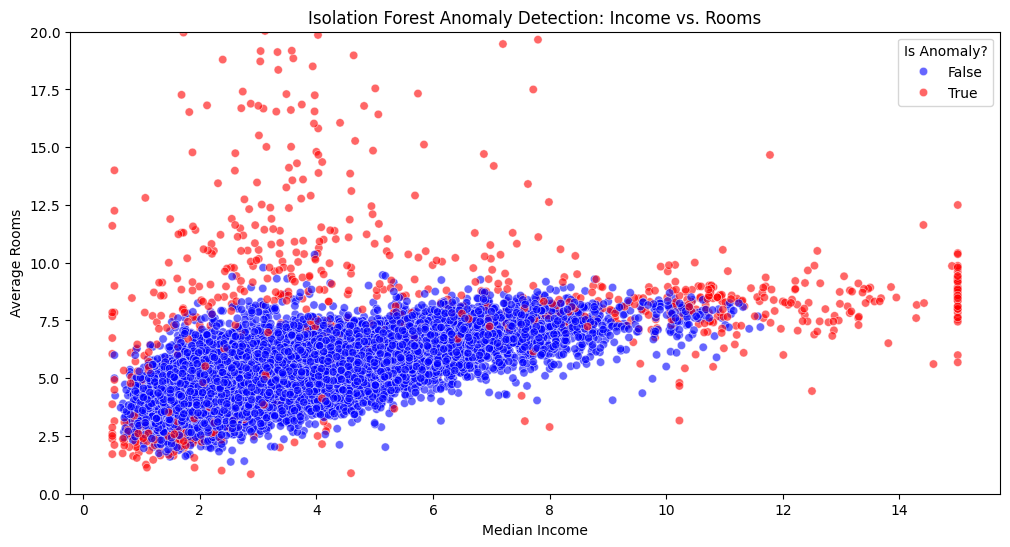

In [24]:
plt.figure(figsize=(12, 6))

# Plot points flagged by Isolation Forest
sns.scatterplot(
    data=df,
    x='MedInc',
    y='AveRooms',
    hue='outlier_iso',
    palette={True: 'red', False: 'blue'},
    alpha=0.6
)

plt.title("Isolation Forest Anomaly Detection: Income vs. Rooms")
plt.xlabel("Median Income")
plt.ylabel("Average Rooms")
plt.ylim(0, 20) # Zoom in to ignore extreme errors
plt.legend(title='Is Anomaly?')
plt.show()


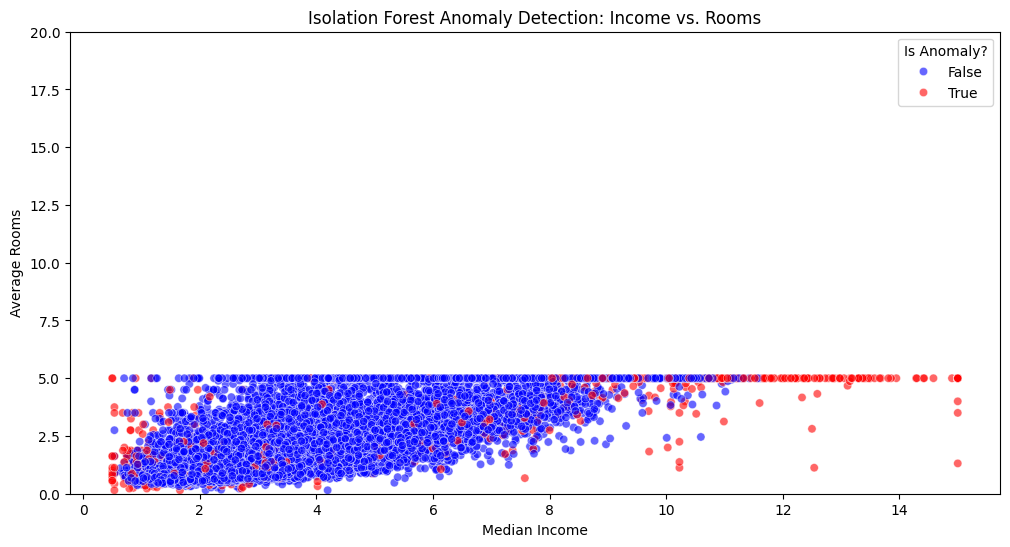

In [25]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']
preds = iso_forest.fit_predict(df[features])
df['outlier_iso'] = preds == -1

plt.figure(figsize=(12, 6))

# Plot points flagged by Isolation Forest
sns.scatterplot(
    data=df,
    x='MedInc',
    y='MedHouseVal',
    hue='outlier_iso',
    palette={True: 'red', False: 'blue'},
    alpha=0.6
)

plt.title("Isolation Forest Anomaly Detection: Income vs. House Value")
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.ylim(0, 20) # Zoom in to ignore extreme errors
plt.legend(title='Is Anomaly?')
plt.show()

=== Comparative Forensics Summary ===
     Group  MedInc_Mean  MedInc_Median  MedHouseVal_Mean  MedHouseVal_Median  \
0   Normal        3.770          3.516             2.037               1.789   
1  Outlier        5.791          4.257             2.668               2.057   

   MedInc_Std  MedInc_MAD  MedHouseVal_Std  MedHouseVal_MAD  
0       1.641       1.032            1.114            0.674  
1       4.145       2.492            1.635            1.103  

=== Inequality Wedge (Outliers) ===
      Variable  Inequality_Wedge
0       MedInc             1.534
1  MedHouseVal             0.611


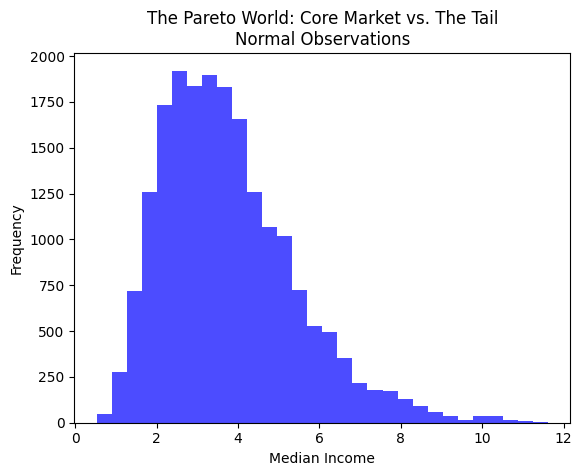

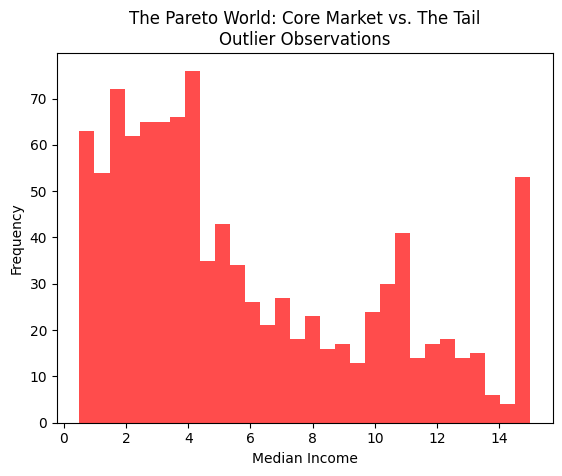

In [30]:
df_normal = df[df["outlier_iso"] == False]
df_outlier = df[df["outlier_iso"] == True]

summary = pd.DataFrame({
    "Group": ["Normal", "Outlier"],

    "MedInc_Mean": [
        df_normal["MedInc"].mean(),
        df_outlier["MedInc"].mean()
    ],
    "MedInc_Median": [
        df_normal["MedInc"].median(),
        df_outlier["MedInc"].median()
    ],

    "MedHouseVal_Mean": [
        df_normal["MedHouseVal"].mean(),
        df_outlier["MedHouseVal"].mean()
    ],
    "MedHouseVal_Median": [
        df_normal["MedHouseVal"].median(),
        df_outlier["MedHouseVal"].median()
    ],
})

import numpy as np

def mad(series):
    med = series.median()
    return np.median(np.abs(series - med))

summary["MedInc_Std"] = [
    df_normal["MedInc"].std(),
    df_outlier["MedInc"].std()
]

summary["MedInc_MAD"] = [
    mad(df_normal["MedInc"]),
    mad(df_outlier["MedInc"])
]

summary["MedHouseVal_Std"] = [
    df_normal["MedHouseVal"].std(),
    df_outlier["MedHouseVal"].std()
]

summary["MedHouseVal_MAD"] = [
    mad(df_normal["MedHouseVal"]),
    mad(df_outlier["MedHouseVal"])
]

print("=== Comparative Forensics Summary ===")
print(summary.round(3))

inequality_wedge = pd.DataFrame({
    "Variable": ["MedInc", "MedHouseVal"],
    "Inequality_Wedge": [
        df_outlier["MedInc"].mean() - df_outlier["MedInc"].median(),
        df_outlier["MedHouseVal"].mean() - df_outlier["MedHouseVal"].median()
    ]
})

print("\n=== Inequality Wedge (Outliers) ===")
print(inequality_wedge.round(3))


import matplotlib.pyplot as plt

# Normal observations
plt.figure()
plt.hist(df_normal["MedInc"], bins=30, color="blue", alpha=0.7)
plt.title("The Pareto World: Core Market vs. The Tail\nNormal Observations")
plt.xlabel("Median Income")
plt.ylabel("Frequency")
plt.show()

# Outliers
plt.figure()
plt.hist(df_outlier["MedInc"], bins=30, color="red", alpha=0.7)
plt.title("The Pareto World: Core Market vs. The Tail\nOutlier Observations")
plt.xlabel("Median Income")
plt.ylabel("Frequency")
plt.show()


In [26]:
df_normal = df[df['outlier_iso'] == False]
df_outlier = df[df['outlier_iso'] == True]

print(f"Shape of df_normal (non-outliers): {df_normal.shape}")
print(f"Shape of df_outlier (outliers): {df_outlier.shape}")

Shape of df_normal (non-outliers): (19608, 11)
Shape of df_outlier (outliers): (1032, 11)


In [27]:
from statsmodels.robust.scale import mad

target_cols = ['MedInc', 'MedHouseVal']

# Calculate statistics for df_normal
normal_stats = {}
for col in target_cols:
    normal_stats[col] = {
        'mean': df_normal[col].mean(),
        'median': df_normal[col].median(),
        'std': df_normal[col].std(),
        'mad': mad(df_normal[col])
    }

# Calculate statistics for df_outlier
outlier_stats = {}
for col in target_cols:
    outlier_stats[col] = {
        'mean': df_outlier[col].mean(),
        'median': df_outlier[col].median(),
        'std': df_outlier[col].std(),
        'mad': mad(df_outlier[col])
    }

print("Descriptive Statistics for Normal Group (df_normal):")
for col, stats in normal_stats.items():
    print(f"  {col}:")
    for stat_name, value in stats.items():
        print(f"    {stat_name}: {value:.2f}")

print("\nDescriptive Statistics for Outlier Group (df_outlier):")
for col, stats in outlier_stats.items():
    print(f"  {col}:")
    for stat_name, value in stats.items():
        print(f"    {stat_name}: {value:.2f}")

Descriptive Statistics for Normal Group (df_normal):
  MedInc:
    mean: 3.77
    median: 3.52
    std: 1.64
    mad: 1.53
  MedHouseVal:
    mean: 2.04
    median: 1.79
    std: 1.11
    mad: 1.00

Descriptive Statistics for Outlier Group (df_outlier):
  MedInc:
    mean: 5.79
    median: 4.26
    std: 4.15
    mad: 3.69
  MedHouseVal:
    mean: 2.67
    median: 2.06
    std: 1.63
    mad: 1.64


## Generate Summary Table

### Subtask:
Create and print a summary table specifically for the outlier group ('df_outlier'), showing the 'Inequality Wedge' (Mean - Median) for both 'MedInc' and 'MedHouseVal'. This table should also include the mean, median, std dev, and MAD for both groups to provide full context.


**Reasoning**:
To generate the summary table, I will iterate through the target columns, calculate the 'Inequality Wedge' for the outlier group, and then compile the statistics for both normal and outlier groups into a dictionary. This dictionary will then be converted into a pandas DataFrame for clear presentation.



In [28]:
summary_data = []

for col in target_cols:
    # Normal group stats
    normal_mean = normal_stats[col]['mean']
    normal_median = normal_stats[col]['median']
    normal_std = normal_stats[col]['std']
    normal_mad = normal_stats[col]['mad']

    # Outlier group stats
    outlier_mean = outlier_stats[col]['mean']
    outlier_median = outlier_stats[col]['median']
    outlier_std = outlier_stats[col]['std']
    outlier_mad = outlier_stats[col]['mad']

    # Calculate Inequality Wedge for outliers
    inequality_wedge = outlier_mean - outlier_median

    summary_data.append({
        'Metric': col,
        'Normal_Mean': normal_mean,
        'Normal_Median': normal_median,
        'Normal_Std': normal_std,
        'Normal_MAD': normal_mad,
        'Outlier_Mean': outlier_mean,
        'Outlier_Median': outlier_median,
        'Outlier_Std': outlier_std,
        'Outlier_MAD': outlier_mad,
        'Outlier_Inequality_Wedge': inequality_wedge
    })

summary_df = pd.DataFrame(summary_data)

print("\nComparative Forensics Report (Normal vs. Outlier Groups):")
print(summary_df.round(2).to_string(index=False))


Comparative Forensics Report (Normal vs. Outlier Groups):
     Metric  Normal_Mean  Normal_Median  Normal_Std  Normal_MAD  Outlier_Mean  Outlier_Median  Outlier_Std  Outlier_MAD  Outlier_Inequality_Wedge
     MedInc         3.77           3.52        1.64        1.53          5.79            4.26         4.15         3.69                      1.53
MedHouseVal         2.04           1.79        1.11        1.00          2.67            2.06         1.63         1.64                      0.61


**Reasoning**:
The next step is to create a 1x2 subplot with histograms of 'MedInc' for `df_normal` and `df_outlier` to visualize the distribution differences between the two groups. This fulfills the next part of the overall task.



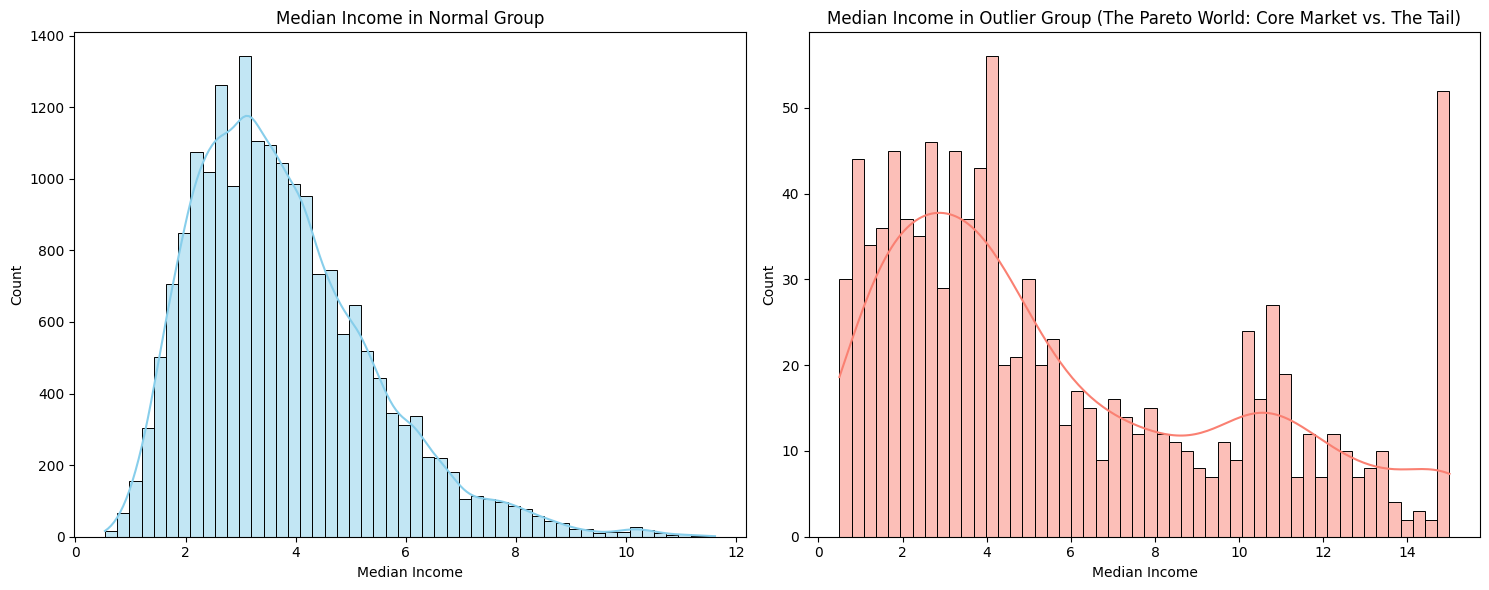

In [29]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_normal['MedInc'], bins=50, kde=True, color='skyblue')
plt.title('Median Income in Normal Group')
plt.xlabel('Median Income')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(df_outlier['MedInc'], bins=50, kde=True, color='salmon')
plt.title('Median Income in Outlier Group (The Pareto World: Core Market vs. The Tail)')
plt.xlabel('Median Income')
plt.ylabel('Count')

plt.tight_layout()
plt.show()